In [24]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Conv1D,Conv2D,Flatten,BatchNormalization,MaxPooling1D,Dropout,Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,MaxPooling2D,ZeroPadding2D,AveragePooling2D
from tensorflow.keras.layers import Activation,Add,Reshape,Permute,LeakyReLU,UpSampling2D,Conv2DTranspose,Concatenate
from tensorflow.keras.layers import Lambda,InputSpec,Layer,Input,Add,ZeroPadding2D,UpSampling2D,MaxPooling2D,Conv2D,Bidirectional,LSTM
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam,SGD
import datetime
from tensorflow.keras.utils import plot_model
import os
import flask
import json


# def load_dataset():

ddata = pd.read_csv('./final_1/data1M.csv')

# DATA

In [25]:
df = ddata
# df.drop(['fwd_header_length'], axis=1, inplace=True)

In [26]:
# drop columns
# df.drop(['protocol'], axis=1, inplace=True)
# df.drop(['Dst Port'], axis=1, inplace=True)

In [27]:
df.describe(include=[int, float])
df.describe(include=[object]).transpose()

,count,unique,top,freq
label,3701213,4,ddos,1000000


# Dealing with duplicates

In [28]:
df.duplicated().any()

True

In [29]:
print('Data size BEFORE deleteting instances with duplicate values: ', df.shape[0], end='\n\n')

# Remove duplicate rows
df.drop_duplicates(inplace=True, keep=False, ignore_index=True)

print('Data size AFTER deleteting instances containing duplicate values: ', df.shape[0])

Data size BEFORE deleteting instances with duplicate values:  3701213

Data size AFTER deleteting instances containing duplicate values:  3569455


Dealing with missing values

In [30]:
df.isnull().sum().sum()
df.isnull().sum() / df.shape[0]

dst_port             0.0
protocol             0.0
flow_duration        0.0
total_fwd_packet     0.0
total_bwd_packets    0.0
                    ... 
idle_mean            0.0
idle_std             0.0
idle_max             0.0
idle_min             0.0
label                0.0
Length: 79, dtype: float64

In [31]:
df.columns[df.isnull().any()]

Index(['flow_bytes_s'], dtype='object')

In [32]:
print('Data size BEFORE deleteting instances with missing values: ', df.shape[0], end='\n\n')

# Remove missing values
df.dropna(axis=0, inplace=True, how="any")

print('Data size AFTER deleteting instances containing missing values: ', df.shape[0])

Data size BEFORE deleteting instances with missing values:  3569455

Data size AFTER deleteting instances containing missing values:  3559769


# Dealing with infinite values

In [33]:
# Checking if all values are finite.
np.all(np.isfinite(df.drop(['label'], axis=1)))

False

In [34]:
# Replace infinite values to NaN
df.replace([-np.inf, np.inf], np.nan, inplace=True)

# Check which labels are related to infinte values
df[(df['flow_bytes_s'].isnull()) & (df['flow_packets_s'].isnull())].label.unique()


array(['Benign', 'ddos', 'password attack'], dtype=object)

In [35]:
print('Data size BEFORE deleteting instances with infinite values: ', df.shape[0], end='\n\n')

# Remove infinte values
df.dropna(axis=0, how='any', inplace=True)

print('Data size AFTER deleteting instances containing infinite values: ', df.shape[0])

Data size BEFORE deleteting instances with infinite values:  3559769

Data size AFTER deleteting instances containing infinite values:  3557855


# Dealing with features with quasi null std deviation

In [36]:
dataset_std = df.std(numeric_only=True)
dataset_std

dst_port             2.090074e+04
protocol             1.308746e+02
flow_duration        6.841985e+08
total_fwd_packet     2.608167e+01
total_bwd_packets    5.696862e+01
                         ...     
active_min           4.052219e+05
idle_mean            6.140962e+14
idle_std             6.420358e+13
idle_max             6.134578e+14
idle_min             6.180568e+14
Length: 78, dtype: float64

In [37]:
# Find Features that meet the threshold
constant_features = [column for column, std in dataset_std.iteritems() if std < 0.01]

# Drop the constant features
df.drop(labels=constant_features, axis=1, inplace=True)
print(constant_features)

C:\Users\fancyma\AppData\Local\Temp\ipykernel_23012\1058764042.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  constant_features = [column for column, std in dataset_std.iteritems() if std < 0.01]


['bwd_psh_flags', 'fwd_urg_flags', 'bwd_urg_flags', 'cwr_flag_count']


# Observing the outliers

In [38]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers with interquartile range
filt = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
print(filt.sum())

C:\Users\fancyma\AppData\Local\Temp\ipykernel_23012\4034545612.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
C:\Users\fancyma\AppData\Local\Temp\ipykernel_23012\4034545612.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
C:\Users\fancyma\AppData\Local\Temp\ipykernel_23012\4034545612.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  filt = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))


ack_flag_count                1351837
active_max                      93760
active_mean                     93760
active_min                      93760
active_std                      64668
                               ...   
total_bwd_packets              292713
total_fwd_packet               318072
total_length_of_bwd_packet     519154
total_length_of_fwd_packet     459237
urg_flag_count                  33015
Length: 75, dtype: int64


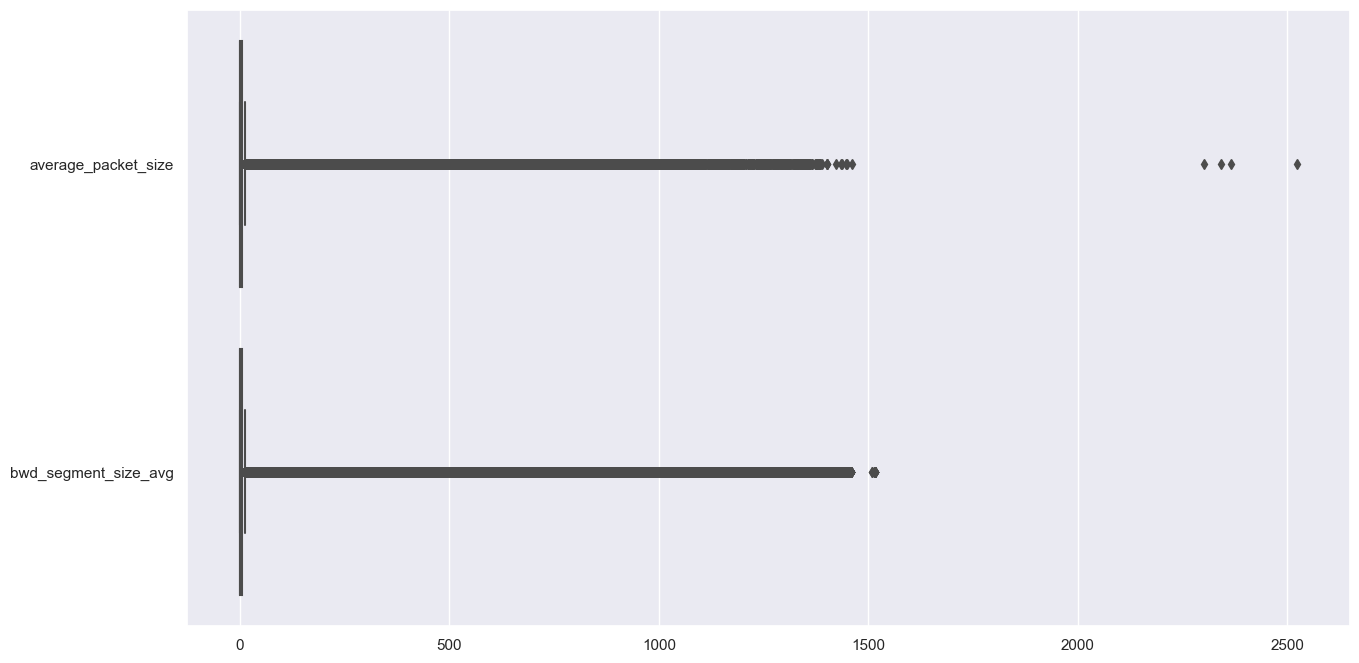

In [39]:
fig = plt.figure(figsize=(15, 8))
sns.boxplot(data=df[['average_packet_size', 'bwd_segment_size_avg']], orient="h")

#plt.title('Summary of some variables containing outliers', fontsize=18)
plt.show()
fig.savefig(os.path.join('./images', 'outliers.pdf'))

Convert the dtype of some features

In [40]:
df[['flow_bytes_s', 'flow_packets_s']] = df[['flow_bytes_s', 'flow_packets_s']].apply(pd.to_numeric)

Create a new feature `Port Category`

In [41]:
# conds = [
#     (df['dst_port'] >= 1) & (df['dst_port'] < 1024),
#     (df['dst_port'] >= 1024) & (df['dst_port'] < 49152),
#     (df['dst_port'] >= 49152) & (df['dst_port'] <= 65535)
# ]

# choices = [
#     "1 - 1023", 
#     "1024 - 49151",
#     "49152 - 65535"
# ]

# df.insert(1, 'destination_port_category', np.select(conds, choices, default="0"))

# Data Exploration

### Correlation Matrix

In [42]:
dataset_corr = df.corr()
dataset_corr.head(5)

C:\Users\fancyma\AppData\Local\Temp\ipykernel_23012\306764757.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset_corr = df.corr()


,dst_port,protocol,flow_duration,total_fwd_packet,total_bwd_packets,total_length_of_fwd_packet,total_length_of_bwd_packet,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,...,fwd_act_data_pkts,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
dst_port,1.000000,-0.024756,-0.002104,-0.039772,-0.032088,-0.009715,-0.012369,-0.225507,-0.078231,-0.224671,...,-0.221426,0.162127,-0.029139,-0.022110,-0.022513,-0.024553,0.161716,-0.018436,0.160494,0.162027
protocol,-0.024756,1.000000,0.000330,0.075512,-0.000666,0.034885,-0.000726,0.074679,0.731285,0.380861,...,0.174232,-0.157695,0.041886,0.158245,0.145423,0.000133,-0.154601,-0.003675,-0.155038,-0.153342
flow_duration,-0.002104,0.000330,1.000000,-0.003282,0.002422,0.000527,0.001813,0.005997,-0.000106,0.004596,...,0.010186,-0.002855,0.003717,0.005940,0.005273,0.002470,-0.006131,0.001437,-0.006029,-0.006196
total_fwd_packet,-0.039772,0.075512,-0.003282,1.000000,0.819415,0.085418,0.812589,0.131178,0.022941,0.101425,...,0.236894,-0.074621,0.080210,0.111656,0.140573,0.061565,-0.082153,0.015933,-0.081034,-0.082790
total_bwd_packets,-0.032088,-0.000666,0.002422,0.819415,1.000000,0.061417,0.996872,0.085596,-0.005236,0.050262,...,0.184532,-0.037731,0.080248,0.060454,0.075087,0.068037,-0.046403,0.009193,-0.045755,-0.046776


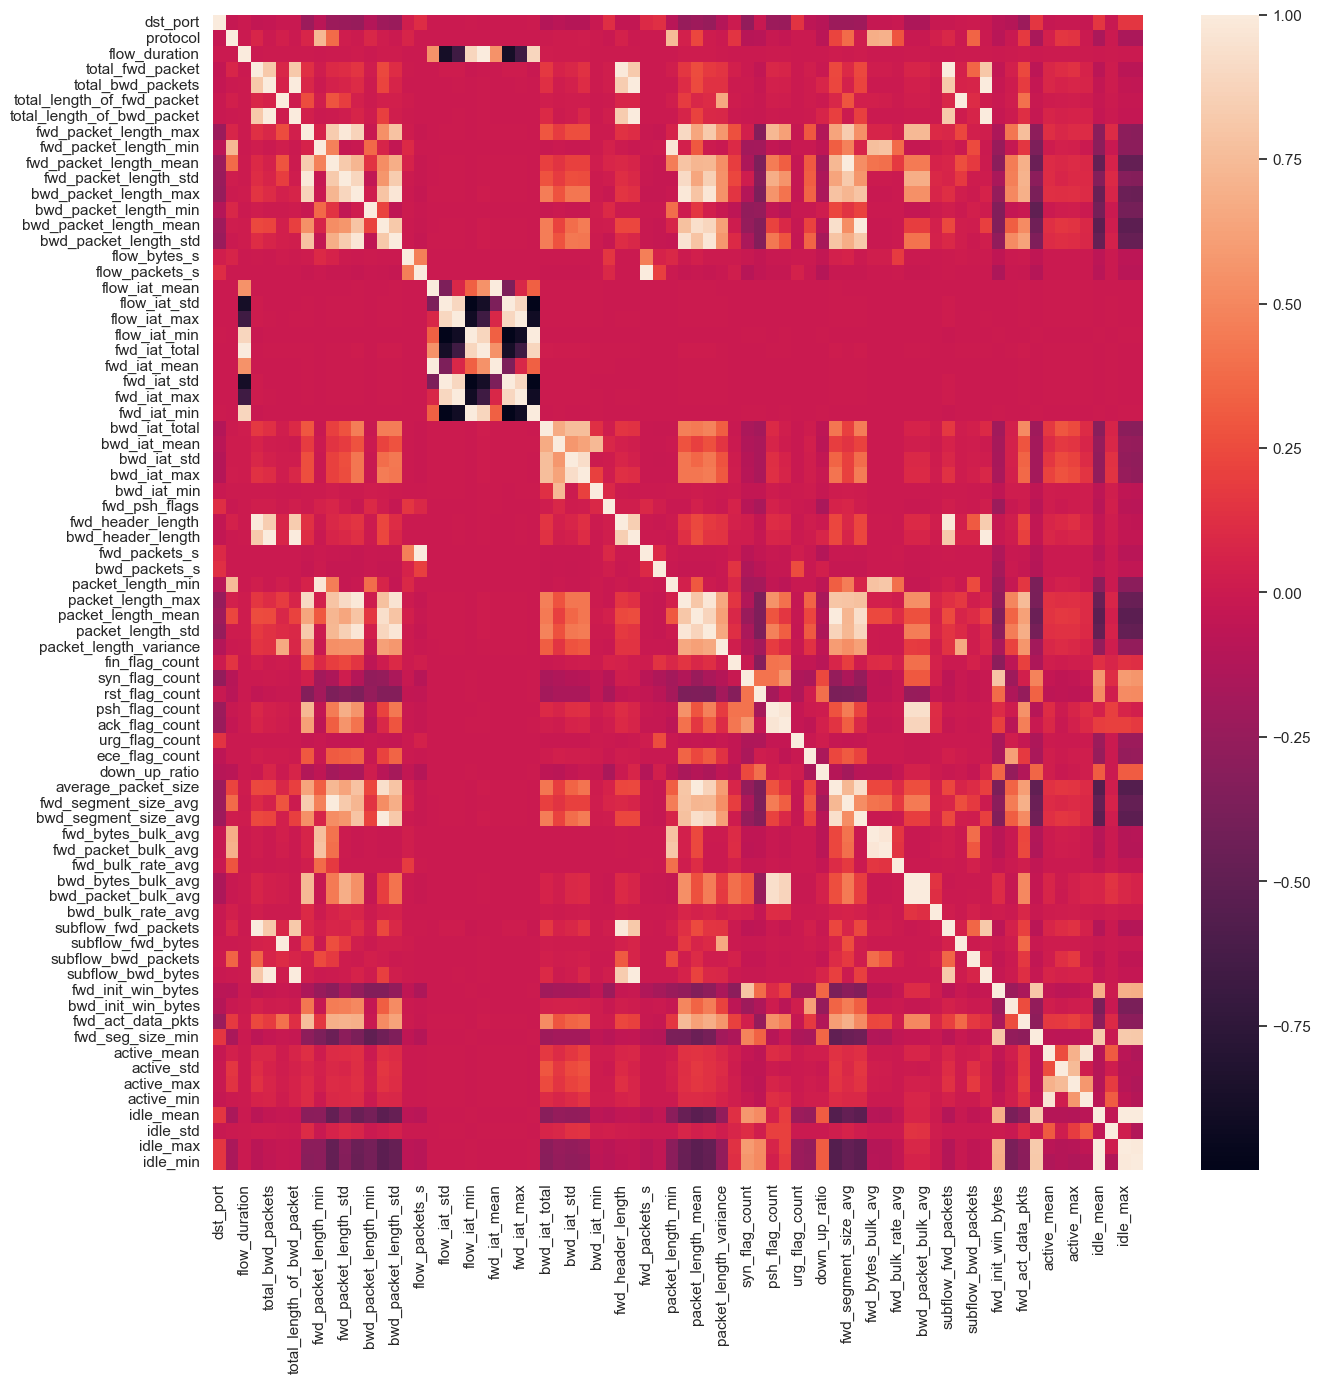

In [43]:
fig = plt.figure(figsize=(15, 15))
sns.set(font_scale=1.0)
ax = sns.heatmap(dataset_corr, annot=False)
fig.savefig(os.path.join('./images', 'correlation matrix.pdf'))

In [44]:
# Create & Apply mask
mask = np.triu(np.ones_like(dataset_corr, dtype=bool))
tri_df = dataset_corr.mask(mask)

# Find Features that meet the threshold
correlated_features = [c for c in tri_df.columns if any(tri_df[c] > 0.98)]
print(correlated_features)
# Drop the highly correlated features
df.drop(labels=correlated_features, axis=1, inplace=True)

['flow_duration', 'total_fwd_packet', 'total_bwd_packets', 'total_length_of_fwd_packet', 'total_length_of_bwd_packet', 'fwd_packet_length_mean', 'bwd_packet_length_max', 'bwd_packet_length_mean', 'flow_packets_s', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'bwd_header_length', 'packet_length_mean', 'bwd_bytes_bulk_avg', 'idle_mean', 'idle_max']


# Information about the data

In [45]:
# drop columns
print(df.info())
train_dataset = df
print(train_dataset['label'].value_counts())
# df.to_csv('./final_1/final_had_p.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3557855 entries, 0 to 3569454
Data columns (total 57 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   dst_port                int64  
 1   protocol                int64  
 2   fwd_packet_length_max   float64
 3   fwd_packet_length_min   float64
 4   fwd_packet_length_std   float64
 5   bwd_packet_length_min   float64
 6   bwd_packet_length_std   float64
 7   flow_bytes_s            float64
 8   fwd_iat_total           float64
 9   fwd_iat_mean            float64
 10  fwd_iat_std             float64
 11  fwd_iat_max             float64
 12  fwd_iat_min             float64
 13  bwd_iat_total           float64
 14  bwd_iat_mean            float64
 15  bwd_iat_std             float64
 16  bwd_iat_max             float64
 17  bwd_iat_min             float64
 18  fwd_psh_flags           int64  
 19  fwd_header_length       int64  
 20  fwd_packets_s           float64
 21  bwd_packets_s           float64

# Port Usage Comparaison

In [46]:
# fig, ax = plt.subplots(figsize=(10,10))

# benign_ports = df.loc[df['Label'] == 'Benign', 'destination_port_category']
# malicious_ports = df.loc[df['Label'] != 'Benign', 'destination_port_category']

# # get rid of rows with specific value
# benign_ports = benign_ports[benign_ports != "0"]
# malicious_ports = malicious_ports[malicious_ports != "0"]

# # sum each port category column
# benign_ports = benign_ports.value_counts()
# malicious_ports = malicious_ports.value_counts()

# indexes = np.arange(3)
# width = 0.4
# rect1 = plt.bar(indexes, benign_ports.values, width, color="steelblue", label="benign")
# rect2 = plt.bar(indexes + width, malicious_ports.values, width, color="indianred", label="malicious")

# def add_text(rect):
#     # add text to top of each bar
#     for r in rect:
#         h = r.get_height()
#         plt.text(r.get_x() + r.get_width()/2, h*1.01, s=format(h, ",") ,fontsize=12, ha='center', va='bottom')

# add_text(rect1)
# add_text(rect2)

# ax.set_xticks(indexes + width / 2)
# ax.set_xticklabels(["1 - 1,023", "1,024 - 49,151", "49,152 - 65,535"])
# plt.title('Distribution of Port Usage\nAccording to Network Activity Type')
# plt.xlabel('Port Range')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)
# plt.show()
# fig.savefig(os.path.join('./images/', 'port_usage_comparison.pdf'))

# Label encoding

In [47]:
# encode label
labelE = LabelEncoder()
train_dataset['label'] = labelE.fit_transform(train_dataset['label'])
train_dataset['label'].value_counts()
y = train_dataset['label']
train_dataset = train_dataset.drop(['label'],axis=1)
# train_dataset = train_dataset.drop(['destination_port_category'],axis=1)


In [48]:
# df.drop(['destination_port_category'], axis=1, inplace=True)

# Normalization

In [49]:
# normalize data
# sc = StandardScaler()
# train_dataset = sc.fit_transform(train_dataset)
# train_dataset = pd.DataFrame(train_dataset,columns=df.columns[:-1])

# Train Test Split

In [50]:
# split data
X_train, X_test, y_train, y_test = train_test_split(train_dataset, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [51]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train.value_counts())

(2134713, 56)
(711571, 56)
(2134713,)
(711571,)
3    600579
1    599796
2    594524
0    339814
Name: label, dtype: int64


# Scaling features to a range

In [52]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer

In [53]:
categorical_features = train_dataset.select_dtypes(exclude=["int64", "float64"]).columns
numeric_features = train_dataset.select_dtypes(exclude=[object]).columns

preprocessor = ColumnTransformer(transformers=[
    ('categoricals', OneHotEncoder(drop='first', sparse=False, handle_unknown='error'), categorical_features),
    ('numericals', QuantileTransformer(), numeric_features)
])

In [68]:
# print(categorical_features)
print(numeric_features)

Index(['dst_port', 'protocol', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_std',
       'bwd_packet_length_min', 'bwd_packet_length_std', 'flow_bytes_s',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'fwd_header_length',
       'fwd_packets_s', 'bwd_packets_s', 'packet_length_min',
       'packet_length_max', 'packet_length_std', 'packet_length_variance',
       'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count',
       'ack_flag_count', 'urg_flag_count', 'ece_flag_count', 'down_up_ratio',
       'average_packet_size', 'fwd_segment_size_avg', 'bwd_segment_size_avg',
       'fwd_bytes_bulk_avg', 'fwd_packet_bulk_avg', 'fwd_bulk_rate_avg',
       'bwd_packet_bulk_avg', 'bwd_bulk_rate_avg', 'subflow_fwd_packets',
       'subflow_fwd_bytes', 'subflow_bwd_packets', 'subflow_bwd_bytes',
       '

Preprocess the features

In [54]:
columns = numeric_features.tolist()
from pickle import dump
X_train = pd.DataFrame(preprocessor.fit_transform(X_train), columns=columns)
dump(preprocessor, open('./normalization/preprocessor.pkl', 'wb'))
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=columns)
X_val = pd.DataFrame(preprocessor.transform(X_val), columns=columns)

In [55]:
DATA_DIR = './data1M/'
X_train.to_pickle(os.path.join(DATA_DIR, 'processed', 'train/train_features.pkl'))
X_val.to_pickle(os.path.join(DATA_DIR, 'processed', 'val/val_features.pkl'))
X_test.to_pickle(os.path.join(DATA_DIR, 'processed', 'test/test_features.pkl'))

y_train.to_pickle(os.path.join(DATA_DIR, 'processed', 'train/train_labels.pkl'))
y_val.to_pickle(os.path.join(DATA_DIR, 'processed', 'val/val_labels.pkl'))
y_test.to_pickle(os.path.join(DATA_DIR, 'processed', 'test/test_labels.pkl'))

# Balance the training set using combination of SMOTE & RandomUnderSampler

In [56]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

def balance_dataset(X, y, undersampling_strategy, oversampling_strategy):

    under_sampler = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=0)
    X_under, y_under = under_sampler.fit_resample(X, y)

    over_sampler = SMOTE(sampling_strategy=oversampling_strategy)
    X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)
    
    return X_bal, y_bal

In [57]:
undersampling_strategy = {
    3    :600579,
    1    :599796,
    2    :594524,
    0    :339814
}

oversampling_strategy = {
    3    :600579,
    1    :599796,
    2    :594524,
    0    :599814
}

# Balance the training set
X_train_bal, y_train_bal = balance_dataset(X_train, y_train, undersampling_strategy, oversampling_strategy)

# Save the balanced training set
X_train_bal.to_pickle(os.path.join(DATA_DIR, 'processed', 'train/train_features_balanced.pkl'))
y_train_bal.to_pickle(os.path.join(DATA_DIR, 'processed', 'train/train_labels_balanced.pkl'))

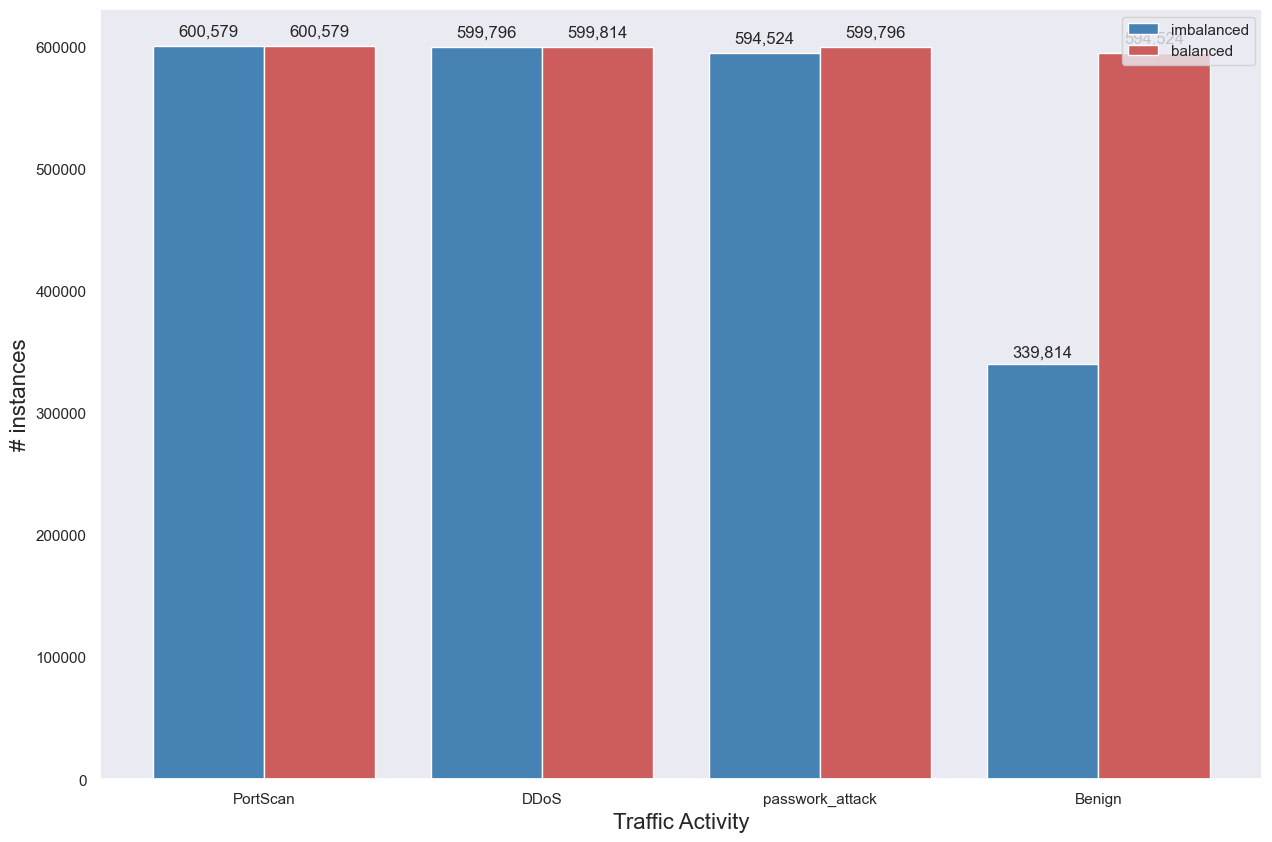

In [58]:
fig, ax = plt.subplots(figsize=(15, 10))

# sum each port category column
imbalanced = y_train.value_counts()
balanced = y_train_bal.value_counts()

indexes = np.arange(4)
width = 0.4
rect1 = plt.bar(indexes, imbalanced.values, width, color="steelblue", label="imbalanced")
rect2 = plt.bar(indexes + width, balanced.values, width, color="indianred", label="balanced")

def add_text(rect):
    """Add text to top of each bar."""
    for r in rect:
        h = r.get_height()
        plt.text(r.get_x() + r.get_width()/2, h*1.01, s=format(h, ",") ,fontsize=12, ha='center', va='bottom')

add_text(rect1)
add_text(rect2)

ax.set_xticks(indexes + width / 2)
ax.set_xticklabels(['PortScan', 'DDoS',  'passwork_attack','Benign'])
plt.xlabel('Traffic Activity', fontsize=16)
plt.ylabel('# instances', fontsize=16)
plt.legend()
plt.grid()
plt.show()
fig.savefig(os.path.join('./images/', 'balanced_dataset.pdf'))

In [59]:
def load_pkl():
    X_train = pd.read_pickle(os.path.join(DATA_DIR, 'processed', 'train/train_features_balanced.pkl'))
    y_train = pd.read_pickle(os.path.join(DATA_DIR, 'processed', 'train/train_labels_balanced.pkl'))
    X_val = pd.read_pickle(os.path.join(DATA_DIR, 'processed', 'val/val_features.pkl'))
    y_val = pd.read_pickle(os.path.join(DATA_DIR, 'processed', 'val/val_labels.pkl'))
    X_test = pd.read_pickle(os.path.join(DATA_DIR, 'processed', 'test/test_features.pkl'))
    y_test = pd.read_pickle(os.path.join(DATA_DIR, 'processed', 'test/test_labels.pkl'))
    return X_train,y_train,X_test,y_test,X_val,y_val

def re_shape_2D(X_train,X_test,y_train,y_test,X_val,y_val):
    X_train = X_train.to_numpy().reshape(len(X_train),X_train.shape[1]//8,8,1)
    X_test = X_test.to_numpy().reshape(len(X_test),X_test.shape[1]//8,8,1)
    X_val = X_val.to_numpy().reshape(len(X_val),X_val.shape[1]//8,8,1)
    return X_train,X_test,y_train,y_test,X_val,y_val

def re_shape_1D(X_train,X_test,y_train,y_test,X_val,y_val):
    X_train = X_train.to_numpy().reshape(len(X_train),X_train.shape[1],1)
    X_test = X_test.to_numpy().reshape(len(X_test),X_test.shape[1],1)
    X_val = X_val.to_numpy().reshape(len(X_val),X_val.shape[1],1)
    return X_train,X_test,y_train,y_test,X_val,y_val

import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model_99(time,Xtrain,ytrain,Xtest,ytest,logdir,epochs=10,batch_size=128,lr =0.001):
    # load model
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=(Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3]),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    # create data generator 
    time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    logdir = logdir + time
    tensorboard_callback = TensorBoard(log_dir=logdir)
    calls = [tensorboard_callback,
            #  EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto'),
            #  ModelCheckpoint(filepath=f'models/{time}/model_{time}.h5',monitor='val_loss',save_best_only=True,mode='auto'),
            #  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,mode='auto',min_delta=0.0001,cooldown=0,min_lr=0)
            ]
    model.fit(Xtrain,ytrain,epochs=epochs,batch_size=batch_size,validation_data=(Xtest,ytest),callbacks=calls,verbose=1)
    return model

def multi_head(time,Xtrain,ytrain,Xtest,ytest,logdir,epochs=10,batch_size=128,lr =0.001):
    input1s = Input(shape=(Xtrain.shape[1],1))
    conv1d_1s1 = Conv1D(filters=32,kernel_size=3,activation='relu',padding='same')(input1s)
    batch_1s1 = BatchNormalization()(conv1d_1s1)
    maxpool_1s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_1s1)
    conv1d_1s2 = Conv1D(filters=32,kernel_size=3,activation='relu',padding='same')(maxpool_1s1)
    batch_1s2 = BatchNormalization()(conv1d_1s2)
    maxpool_1s2 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_1s2)
    flat1 = Flatten()(maxpool_1s2)

    input2s = Input(shape=(Xtrain.shape[1],1))
    conv1d_2s1 = Conv1D(filters=64,kernel_size=5,activation='relu',padding='same')(input2s)
    batch_2s1 = BatchNormalization()(conv1d_2s1)
    maxpool_2s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_2s1)
    conv1d_2s2 = Conv1D(filters=64,kernel_size=5,activation='relu',padding='same')(maxpool_2s1)
    batch_2s2 = BatchNormalization()(conv1d_2s2)
    maxpool_2s2 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_2s2)
    flat2 = Flatten()(maxpool_2s2)
    
    input3s = Input(shape=(Xtrain.shape[1],1))
    conv1d_3s1 = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(input3s)
    batch_3s1 = BatchNormalization()(conv1d_3s1)
    maxpool3 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_3s1)
    conv1d_3s2 = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(maxpool3)
    batch_3s2 = BatchNormalization()(conv1d_3s2)
    maxpool_3s2 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_3s2)
    flat3 = Flatten()(maxpool_3s2)

    concat = concatenate([flat1,flat2,flat3])
    dense1 = Dense(256,activation='relu')(concat)
    drop = Dropout(0.2)(dense1)
    dense2 = Dense(4,activation='softmax')(drop)
    model = Model(inputs=[input1s,input2s,input3s],outputs=dense2)
    #plot model
    plot_model(model, to_file=f'models/{time}/model_{time}.png', show_shapes=True, show_layer_names=True)

    opt = SGD(lr=lr, momentum=0.9)  
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    logdir = logdir + time
    tensorboard_callback = TensorBoard(log_dir=logdir)
    calls = [tensorboard_callback,
             EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto'),
             ModelCheckpoint(filepath=f'models/{time}/model_{time}.h5',monitor='val_loss',save_best_only=True,mode='auto'),
             ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,mode='auto',min_delta=0.0001,cooldown=0,min_lr=0)
            ]
    model.fit([Xtrain,Xtrain,Xtrain],ytrain,epochs=epochs,batch_size=batch_size,validation_data=([Xtest,Xtest,Xtest],ytest),callbacks=[tensorboard_callback],verbose=1)
    # _,acc = model.evaluate([Xtest,Xtest,Xtest],ytest,verbose=0)
    # print("Accuracy: %.2f%%" % (acc*100))
    return model

def CNN_normal(time,Xtrain,ytrain,Xtest,ytest,logdir,epochs=10,batch_size=128,lr =0.001):
    # define model conv2D
    input1s = Input(shape=(Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3]))
    conv1 = Conv2D(32,(3,3),activation='relu',padding='same')(input1s)
    conv2 = Conv2D(32,(3,3),activation='relu',padding='same')(conv1)
    bat = BatchNormalization()(conv2)
    pool1 = MaxPooling2D((3,3))(bat)
    flat1 = Flatten()(pool1)
    dense1 = Dense(256,activation='relu')(flat1)
    drop = Dropout(0.2)(dense1)
    dense2 = Dense(4,activation='softmax')(drop)
    model = Model(inputs=input1s,outputs=dense2)
    #plot model
    plot_model(model, to_file=f'models/{time}/model_{time}.png', show_shapes=True, show_layer_names=True)

    opt = SGD(lr=lr, momentum=0.9)  
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    logdir = logdir + time
    tensorboard_callback = TensorBoard(log_dir=logdir)
    calls = [tensorboard_callback,
            EarlyStopping(monitor='val_acc', patience=2, verbose=1, mode='auto'),
            ModelCheckpoint(filepath=f'./models/{time}/model_checkpoint{time}.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
            #  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,mode='auto',min_delta=0.0001,cooldown=0,min_lr=0)
            ]
    model.fit(Xtrain,ytrain,epochs=epochs,batch_size=batch_size,validation_data=(Xtest,ytest),callbacks=calls,verbose=1)
    return model

In [60]:
X_train,y_train,X_test,y_test,X_val,y_val = load_pkl()
X_train,X_test,y_train,y_test,X_val,y_val = re_shape_1D(X_train,X_test,y_train,y_test,X_val,y_val)

In [61]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2394713, 56, 1)
(711571, 56, 1)
(2394713,)
(711571,)


In [62]:
# %tensorboard --logdir logs/fit
time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
os.mkdir(f'./models/{time}')
logdir="logs/multi/" + time +'/'
model = multi_head(time,X_train,y_train,X_test,y_test,logdir,10,128)
model.save(f'models/{time}/model_{time}.h5')

c:\Users\fancyma\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
18709/18709 [==============================] - 406s 21ms/step - loss: 0.0156 - accuracy: 0.9948 - val_loss: 0.0378 - val_accuracy: 0.9861
Epoch 2/10
18709/18709 [==============================] - 391s 21ms/step - loss: 0.0085 - accuracy: 0.9971 - val_loss: 0.0056 - val_accuracy: 0.9982
Epoch 3/10
18709/18709 [==============================] - 425s 23ms/step - loss: 0.0067 - accuracy: 0.9976 - val_loss: 0.0120 - val_accuracy: 0.9945
Epoch 4/10
18709/18709 [==============================] - 396s 21ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 0.0640 - val_accuracy: 0.9861
Epoch 5/10
18709/18709 [==============================] - 406s 22ms/step - loss: 0.0050 - accuracy: 0.9981 - val_loss: 0.0047 - val_accuracy: 0.9984
Epoch 6/10
18709/18709 [==============================] - 388s 21ms/step - loss: 0.0045 - accuracy: 0.9983 - val_loss: 0.0043 - val_accuracy: 0.9985
Epoch 7/10
18709/18709 [==============================] - 386s 21ms/step - loss: 0.0043 - accuracy: 0.9984

In [63]:
da = pd.DataFrame(y_test)
da.value_counts()

label
1        200097
3        199911
2        198634
0        112929
dtype: int64

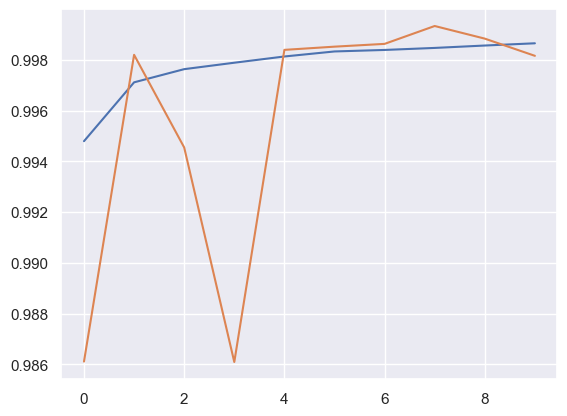

In [64]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])